In [1]:
# --- paths & config (match your working notebook) ---
from types import SimpleNamespace
import os, sys, torch

# Add repo to path
PROJECT_ROOT = "/home/heydari/FHHI-XAI/"
sys.path.append(PROJECT_ROOT)
sys.path.append(os.path.join(PROJECT_ROOT, "datasets"))

# Flood dataset root (kept as in your notebook)
FLOOD_ROOT = os.path.join(PROJECT_ROOT, "/home/heydari/FHHI-XAI/data/General_Flood_v3")

# Config
CFG = SimpleNamespace()
CFG.device      = "cuda" if torch.cuda.is_available() else "cpu"
CFG.split       = "val"     # or "test"
CFG.batch_size  = 2
CFG.num_workers = 0
CFG.num_classes = 2
CFG.img_size    = (1280, 720)  # 720p letterbox target
CFG.viz_rows    = 3
CFG.max_batches = None


print("Device:", CFG.device, "| Split:", CFG.split, "| Target size:", CFG.img_size)

# --- dataset class exactly as you used it ---
from src.datasets.flood_dataset import FloodDataset as FD
print("FloodDataset imported:", FD)

# --- model via LCRP.models.get_model (no extra knobs) ---
from LCRP.models import get_model

def load_pidnet(model_name="pidnet", num_classes=2, weights_path=None, device=CFG.device):
    model = get_model(model_name='pidnet')  # your notebook calls with fixed key
    model = model.to(device).eval()
    if weights_path and os.path.exists(weights_path):
        ckpt = torch.load(weights_path, map_location="cpu")
        sd = ckpt.get("state_dict", ckpt)
        sd = {k[7:] if k.startswith("module.") else k: v for k, v in sd.items()}
        missing, unexpected = model.load_state_dict(sd, strict=False)
        print("Loaded weights. Missing:", missing, "Unexpected:", unexpected)
    return model

# put your actual checkpoint here (same as notebook)
PIDNET_WEIGHTS = "/home/heydari/FHHI-XAI/LCRP/models/checkpoints/flood_s_best_pidnet_modified.pt"
pidnet = load_pidnet(weights_path=PIDNET_WEIGHTS, device=CFG.device)
print("Model ready.")


/home/heydari/.virtualenvs/TEMA-FHHI-PY/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda | Split: val | Target size: (1280, 720)
FloodDataset imported: <class 'src.datasets.flood_dataset.FloodDataset'>
Loaded weights. Missing: [] Unexpected: []
Model ready.


In [2]:
import os, sys, torch, numpy as np
from PIL import Image
from types import SimpleNamespace
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader

# --- assume Cell 1 already defined CFG, FLOOD_ROOT, FD, pidnet, etc. ---
# CFG.img_size is your target (720, 1280) and CFG.num_classes = 2

# ---------- letterbox + normalize (ImageNet) ----------
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def _to_tensor_unit(pil_rgb: Image.Image) -> torch.Tensor:
    return transforms.ToTensor()(pil_rgb)  # (3,H,W) in [0,1]

def _normalize_tensor(x: torch.Tensor,
                      mean=IMAGENET_MEAN, std=IMAGENET_STD) -> torch.Tensor:
    return transforms.Normalize(mean, std)(x)

def _letterbox_pil(pil_rgb: Image.Image, size, fill=(0,0,0)):
    """Pad to target (H,W) without warping; return normalized tensor + meta."""
    h0, w0 = pil_rgb.height, pil_rgb.width
    Ht, Wt = size
    r = min(Wt / w0, Ht / h0)
    nw, nh = int(round(w0 * r)), int(round(h0 * r))
    im_res = pil_rgb.resize((nw, nh), resample=Image.BILINEAR)

    canvas = Image.new("RGB", (Wt, Ht), fill)
    pad_w = (Wt - nw) // 2
    pad_h = (Ht - nh) // 2
    canvas.paste(im_res, (pad_w, pad_h))

    x = _normalize_tensor(_to_tensor_unit(canvas))  # (3,Ht,Wt)
    meta = {
        "pad_w": pad_w, "pad_h": pad_h,
        "scaled_w": nw, "scaled_h": nh,
        "target_w": Wt, "target_h": Ht,
        "orig_w": w0, "orig_h": h0,
    }
    return x, meta

def preprocess_input_image(img, size):
    """
    Accepts PIL.Image | np.ndarray | torch.Tensor(3,H,W in [0..1]).
    Returns normalized tensor (3,Ht,Wt) and meta dict.
    """
    if isinstance(img, np.ndarray):
        if img.ndim == 3 and img.shape[2] == 3:
            img = img[..., ::-1]  # BGR->RGB if from cv2
        if img.dtype != np.uint8:
            img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        pil = Image.fromarray(img, "RGB")
    elif torch.is_tensor(img):
        assert img.ndim == 3 and img.shape[0] == 3, "Tensor image must be (3,H,W)"
        arr = (img.permute(1,2,0).clamp(0,1).cpu().numpy() * 255).astype(np.uint8)
        pil = Image.fromarray(arr, "RGB")
    elif isinstance(img, Image.Image):
        pil = img.convert("RGB")
    else:
        raise TypeError(f"Unsupported image type: {type(img)}")

    x, meta = _letterbox_pil(pil, size)
    return x, meta

def _to_uint8_rgb_np(x):
    if isinstance(x, Image.Image): return np.asarray(x.convert("RGB"))
    if torch.is_tensor(x):
        x = (x.clamp(0,1).permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        return x
    if isinstance(x, np.ndarray):
        if x.ndim == 2: x = np.stack([x]*3, axis=-1)
        if x.dtype != np.uint8: x = (x.clip(0,1)*255).astype(np.uint8)
        return x
    return np.asarray(x)

_mask_resize = transforms.Resize(CFG.img_size, interpolation=InterpolationMode.NEAREST)

def _mask_to_tensor(mask):
    # robustly map to {0,1} long tensor at TARGET size (for batching only)
    if isinstance(mask, Image.Image):
        m = np.asarray(_mask_resize(mask.convert("L")))
    elif isinstance(mask, np.ndarray):
        if mask.ndim == 3: mask = mask[..., 0]
        m = np.asarray(Image.fromarray(mask).convert("L").resize(CFG.img_size[::-1], Image.NEAREST))
    elif torch.is_tensor(mask):
        return mask.long()
    else:
        raise TypeError(f"Unsupported mask type: {type(mask)}")
    uniq = set(np.unique(m).tolist())
    if   uniq <= {0,255}: m = (m > 127).astype(np.uint8)
    elif uniq <= {0,1}:   m = m.astype(np.uint8)
    elif uniq <= {0,2}:   m = (m >= 1).astype(np.uint8)
    else:                 m = (m > 0).astype(np.uint8)
    return torch.from_numpy(m).long()

# ---------- collate returns (imgs@TARGET, masks@TARGET, origs, metas) ----------
def flood_collate_safe(batch):
    imgs_t, masks_t, origs, metas = [], [], [], []
    for sample in batch:
        if len(sample) == 3:
            img, mask, orig = sample
        else:
            img, mask = sample
            orig = img
        origs.append(_to_uint8_rgb_np(orig))
        x, meta = preprocess_input_image(img, CFG.img_size)
        imgs_t.append(x)
        masks_t.append(_mask_to_tensor(mask))
        metas.append(meta)
    imgs_t  = torch.stack(imgs_t, 0)
    masks_t = torch.stack(masks_t, 0)
    return imgs_t, masks_t, origs, metas

# ---------- dataset & dataloader ----------
from src.datasets.flood_dataset import FloodDataset as FD

try:
    ds = FD(root_dir=FLOOD_ROOT, split=CFG.split, image_size=None)
except TypeError:
    ds = FD(FLOOD_ROOT, CFG.split)

loader = DataLoader(
    ds, batch_size=CFG.batch_size, shuffle=False,
    num_workers=CFG.num_workers, pin_memory=True, collate_fn=flood_collate_safe
)

print("DataLoader ready:", len(ds), "samples | batch_size:", CFG.batch_size)


DataLoader ready: 244 samples | batch_size: 2


=== KPIs on subset ===
IoU  bg: 0.8373 | flood: 0.8290
Prec bg: 0.8627, Rec bg: 0.9660, F1 bg: 0.9115
Prec fl: 0.9640, Rec fl: 0.8555, F1 fl: 0.9065
mIoU: 0.8332 | Pixel Acc: 0.9090


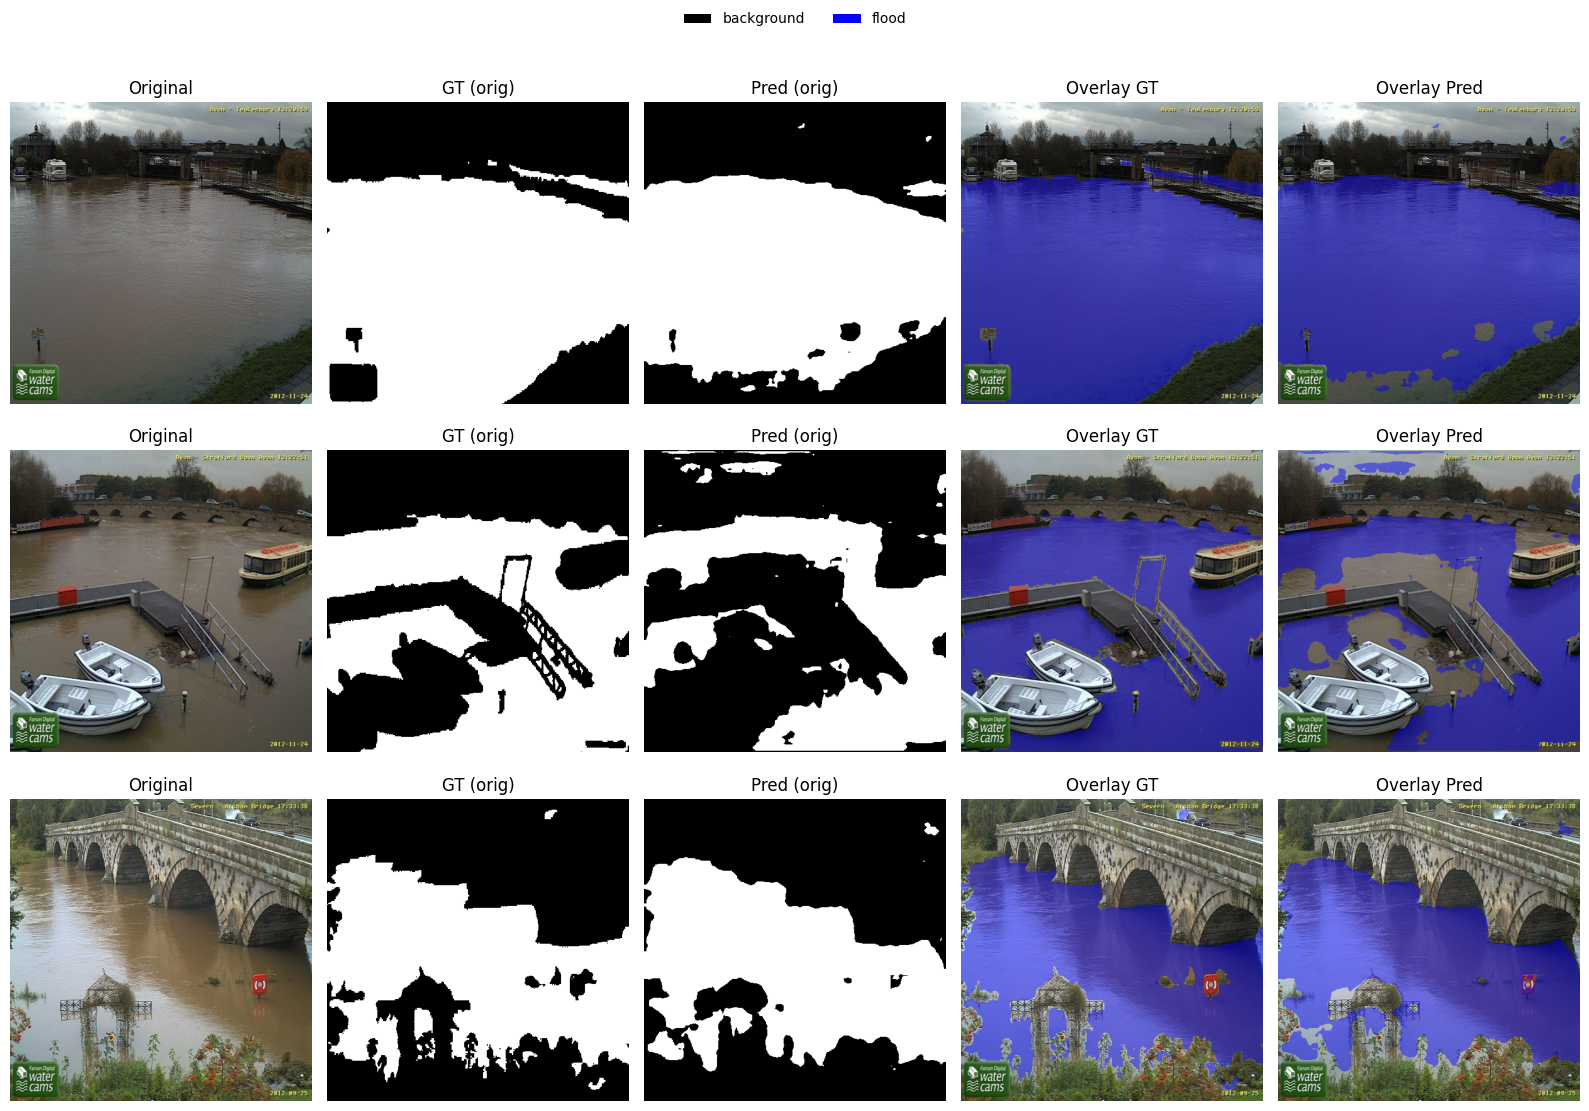

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from PIL import Image

# ----- inference (NO TTA, NO thresholds/bias; argmax) -----
def _predict_logits(model, x):
    out = model(x)
    if isinstance(out, (list, tuple)):
        out = out[0]
    if isinstance(out, dict):
        for k in ("out", "logits", "pred", "y"):
            if k in out:
                out = out[k]
                break
    return out  # (B,C,h,w)

def _unletterbox_mask(mask_hw: torch.Tensor, meta: dict):
    """Crop TARGET mask back to valid content region (remove padding)."""
    ph, pw = meta["pad_h"], meta["pad_w"]
    sh, sw = meta["scaled_h"], meta["scaled_w"]
    return mask_hw[ph:ph+sh, pw:pw+sw]

@torch.no_grad()
def infer_batch_no_tta(model, imgs, metas, target_size):
    """
    Argmax @ target_size (e.g., 720x1280) -> unletterbox (valid region) -> resize to ORIGINAL (H0,W0).
    Returns: list of np.uint8 masks at original resolution.
    """
    x = imgs.to(CFG.device)
    logits = _predict_logits(model, x)  # (B,C,h,w)
    if logits.shape[-2:] != target_size:
        logits = F.interpolate(logits, size=target_size, mode="bilinear", align_corners=False)
    pred_tgt = torch.argmax(logits, dim=1)  # (B,Ht,Wt)

    preds_resized = []
    for i in range(pred_tgt.shape[0]):
        pi = pred_tgt[i].cpu().long()
        mi = metas[i]
        # unpad to valid region
        pi_valid = _unletterbox_mask(pi, mi)  # (scaled_h, scaled_w)
        # resize back to original size
        H0, W0 = mi["orig_h"], mi["orig_w"]
        pi_np = pi_valid.unsqueeze(0).unsqueeze(0).float()
        pi_orig = F.interpolate(pi_np, size=(H0, W0), mode="nearest").squeeze(0).squeeze(0).long()
        preds_resized.append(pi_orig.numpy().astype(np.uint8))
    return preds_resized

# ----- KPI helpers (numpy-friendly confmat, IoU, precision/recall/F1, pixel acc) -----
def fast_confmat_numpy(pred_np, target_np, num_classes=2):
    pred   = torch.from_numpy(pred_np.reshape(-1))
    target = torch.from_numpy(target_np.reshape(-1))
    mask = (target >= 0) & (target < num_classes)
    idx = num_classes*target[mask] + pred[mask]
    return torch.bincount(idx, minlength=num_classes**2).reshape(num_classes, num_classes)

def iou_from_confmat(conf: torch.Tensor):
    cm = conf.numpy().astype(np.float64)
    tp = np.diag(cm)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    denom = tp + fp + fn
    return np.divide(tp, denom, out=np.zeros_like(tp, float), where=denom > 0)

def precision_recall_f1(conf: torch.Tensor):
    cm = conf.numpy().astype(np.float64)
    tp = np.diag(cm)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    prec = np.divide(tp, tp+fp, out=np.zeros_like(tp, float), where=(tp+fp) > 0)
    rec  = np.divide(tp, tp+fn, out=np.zeros_like(tp, float), where=(tp+fn) > 0)
    f1   = np.divide(2*prec*rec, prec+rec, out=np.zeros_like(tp, float), where=(prec+rec) > 0)
    return {"precision": prec, "recall": rec, "f1": f1}

def pixel_accuracy(conf: torch.Tensor):
    cm = conf.numpy().astype(np.float64)
    return float(np.diag(cm).sum() / cm.sum()) if cm.sum() > 0 else 0.0

# ----- subset evaluation (ORIGINAL size) with visualization -----
@torch.no_grad()
def eval_subset(model, loader, num_classes=2, n_batches=5, viz_rows=3, target_size=CFG.img_size):
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)
    got = 0
    examples = []

    for bidx, (imgs, target_resized, origs, metas) in enumerate(loader):
        # predictions at ORIGINAL size
        preds_list = infer_batch_no_tta(model, imgs, metas, target_size)

        # upsample TARGET-size GT back to original size (mirrors your good notebook)
        for i in range(len(preds_list)):
            H0, W0 = metas[i]["orig_h"], metas[i]["orig_w"]
            gt_t = target_resized[i].unsqueeze(0).unsqueeze(0).float()
            gt_orig = F.interpolate(gt_t, size=(H0, W0), mode="nearest").squeeze(0).squeeze(0).long().cpu().numpy().astype(np.uint8)

            pr = preds_list[i]
            conf += fast_confmat_numpy(pr, gt_orig, num_classes)

            # collect a few examples for display
            if len(examples) < viz_rows:
                img0 = origs[i]
                if isinstance(img0, torch.Tensor):
                    img0 = (img0.permute(1,2,0).cpu().numpy() * 255).clip(0,255).astype(np.uint8)
                if img0.ndim == 2:
                    img0 = np.repeat(img0[..., None], 3, axis=2)
                if img0.shape[:2] != (H0, W0):
                    img0 = np.array(Image.fromarray(img0).resize((W0, H0), Image.BILINEAR))
                examples.append((img0, gt_orig, pr))

        got += 1
        if n_batches is not None and got >= n_batches:
            break

    iou = iou_from_confmat(conf)
    prf = precision_recall_f1(conf)
    miou = float(iou.mean())
    pixacc = pixel_accuracy(conf)

    # pretty print exactly like your high-score cell
    print("=== KPIs on subset ===")
    print(f"IoU  bg: {iou[0]:.4f} | flood: {iou[1]:.4f}")
    print(f"Prec bg: {prf['precision'][0]:.4f}, Rec bg: {prf['recall'][0]:.4f}, F1 bg: {prf['f1'][0]:.4f}")
    print(f"Prec fl: {prf['precision'][1]:.4f}, Rec fl: {prf['recall'][1]:.4f}, F1 fl: {prf['f1'][1]:.4f}")
    print(f"mIoU: {miou:.4f} | Pixel Acc: {pixacc:.4f}")

    # visualization
    def overlay(img_rgb, mask01, color=(0, 0, 255), alpha=0.45):
        base = img_rgb.astype(np.float32).copy()
        m = (mask01 > 0)
        ov = np.zeros_like(base)
        ov[..., 0] = color[0]; ov[..., 1] = color[1]; ov[..., 2] = color[2]
        base[m] = (1 - alpha) * base[m] + alpha * ov[m]
        return base.astype(np.uint8)

    if len(examples):
        rows = len(examples)
        fig, axes = plt.subplots(rows, 5, figsize=(16, 3.8 * rows), squeeze=False)
        for r, (img, gt, pr) in enumerate(examples):
            axes[r, 0].imshow(img);                      axes[r, 0].set_title("Original");      axes[r, 0].axis("off")
            axes[r, 1].imshow(gt, cmap="gray", vmin=0, vmax=1); axes[r, 1].set_title("GT (orig)");  axes[r, 1].axis("off")
            axes[r, 2].imshow(pr, cmap="gray", vmin=0, vmax=1); axes[r, 2].set_title("Pred (orig)");axes[r, 2].axis("off")
            axes[r, 3].imshow(overlay(img, gt > 0));     axes[r, 3].set_title("Overlay GT");   axes[r, 3].axis("off")
            axes[r, 4].imshow(overlay(img, pr > 0));     axes[r, 4].set_title("Overlay Pred"); axes[r, 4].axis("off")

        handles = [
            Patch(facecolor='black', label='background'),
            Patch(facecolor='blue',  label='flood')
        ]
        fig.legend(handles=handles, loc='upper center', ncol=2, frameon=False)
        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

    return iou, miou, conf

# ---- run (subset-style evaluation; no preprocessing done here) ----
iou_sub, miou_sub, conf_sub = eval_subset(
    pidnet, loader, num_classes=CFG.num_classes,
    n_batches=5, viz_rows=CFG.viz_rows, target_size=CFG.img_size
)


In [ ]:
!pkill -u heydari -f jupyter
